<a href="https://colab.research.google.com/github/Kushvith/hp-unlocked-challenge-3-signal-processing-tensorflow/blob/main/voice_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing required modules

In [3]:
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os,csv
import IPython as IPD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,Dropout
from itertools import groupby
import zipfile
from google.colab import drive

In [4]:
!pip install tensorflow_io


# Downloading the dataset from the kaggle

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "/content/drive/My Drive/kaggle.json"


'/content/drive/My Drive/kaggle.json'


In [7]:
mkdir ~/.kaggle

In [8]:
cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/

In [9]:
# url for the dataset
# https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
! kaggle datasets download kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 98% 593M/604M [00:11<00:00, 38.2MB/s]
100% 604M/604M [00:11<00:00, 55.2MB/s]


In [10]:
zip = zipfile.ZipFile('/content/z-by-hp-unlocked-challenge-3-signal-processing.zip')
zip.extractall()

In [11]:
capuchin_data = os.path.join('Parsed_Capuchinbird_Clips')
other_data = os.path.join('Parsed_Not_Capuchinbird_Clips')
forest_data = os.path.join('Forest Recordings')

In [12]:
downsample_rate = 16000
Epochs = 10
cap_file = os.path.join('Parsed_Capuchinbird_Clips','XC178167-0.wav')
not_cap_file = os.path.join('Parsed_Not_Capuchinbird_Clips','Crickets-chirping-at-night-1.wav')


In [13]:
def downsample_audio(filename,downsampling,is_forest=False):
  if is_forest:
    file = tfio.audio.AudioIOTensor(filename)
    # convert to tensor and combine the channels
    to_tensor = file.to_tensor()
    to_tensor = tf.math.reduce_sum(to_tensor,axis=1)/2
    smaple_rate = tf.cast(file.rate,dtype=tf.int64)
    wav = tfio.audio.resample(to_tensor,rate_in=smaple_rate,rate_out=downsampling)
  else:
    file = tf.io.read_file(filename)
    wav,sample_rate = tf.audio.decode_wav(file,desired_channels=1)
    wav = tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)
    wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=downsampling)
  return wav



# playing some audio

# lets watch how capuchin birds sounds like

In [14]:
IPD.display.Audio(cap_file)

# lets play other audio

In [15]:
IPD.display.Audio(not_cap_file)

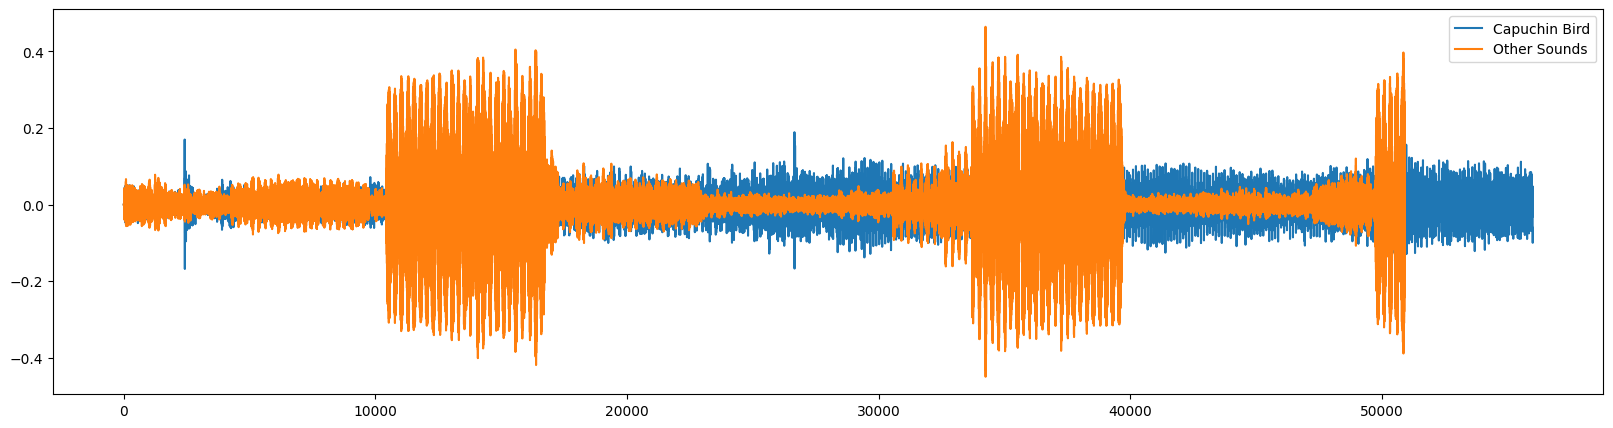

In [16]:
# Downsample and plot
plt.figure(figsize=(20,5))
plt.plot(downsample_audio(cap_file,downsample_rate))
plt.plot(downsample_audio(not_cap_file,downsample_rate))
plt.legend(['Capuchin Bird','Other Sounds'])
plt.show()

# stats on the capuchin bird

In [17]:
lengths = []
for file in os.listdir(capuchin_data):
  downsampled_audio = downsample_audio(os.path.join(capuchin_data,file),downsample_rate)
  lengths.append(len(downsampled_audio))

In [18]:
print(f'the longest call of the capuchin bird is {max(lengths)/downsample_rate} seconds')
print(f'the shorest call of the capuchin bird is {min(lengths)/downsample_rate} seconds')
print(f'the average call of the capuchin bird is {round(sum(lengths))/len(lengths)/downsample_rate} seconds')

the longest call of the capuchin bird is 5.0 seconds
the shorest call of the capuchin bird is 2.0 seconds
the average call of the capuchin bird is 3.384791474654378 seconds


In [19]:
length = int(round(sum(lengths)/len(lengths),-3))
length

54000

# Loading the data to the pipeline

In [20]:
pos = tf.data.Dataset.list_files(capuchin_data+'/*.wav')
neg = tf.data.Dataset.list_files(other_data+'/*.wav')

# add the label with the tensors

pos_dataset = tf.data.Dataset.zip(pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))
neg_dataset = tf.data.Dataset.zip(neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))

full_data = pos_dataset.concatenate(neg_dataset)


In [21]:
def preprocess(filename,label):
  file_audio = downsample_audio(filename,downsample_rate)
  file_audio = file_audio[:length]
  zero_padding = tf.zeros([length]-tf.shape(file_audio),dtype=tf.float32)
  file_audio = tf.concat([zero_padding,file_audio],0)
  spectogram = tf.abs(tf.signal.stft(file_audio,frame_length=320,frame_step=32))
  spectogram = tf.expand_dims(spectogram,axis=2)
  return spectogram,label

In [22]:
def preprocess_data_full_audio(sample,label):
  file_audio = sample[0]
  zero_padding = tf.zeros([length]-tf.shape(file_audio),dtype=tf.float32)
  file_audio = tf.concat([zero_padding,file_audio],0)
  spectogram = tf.abs(tf.signal.stft(file_audio,frame_length=320,frame_step=32))
  spectogram = tf.expand_dims(spectogram,axis=2)
  return spectogram,label

# plot the spectogram

1678 (1, 257, 1678)


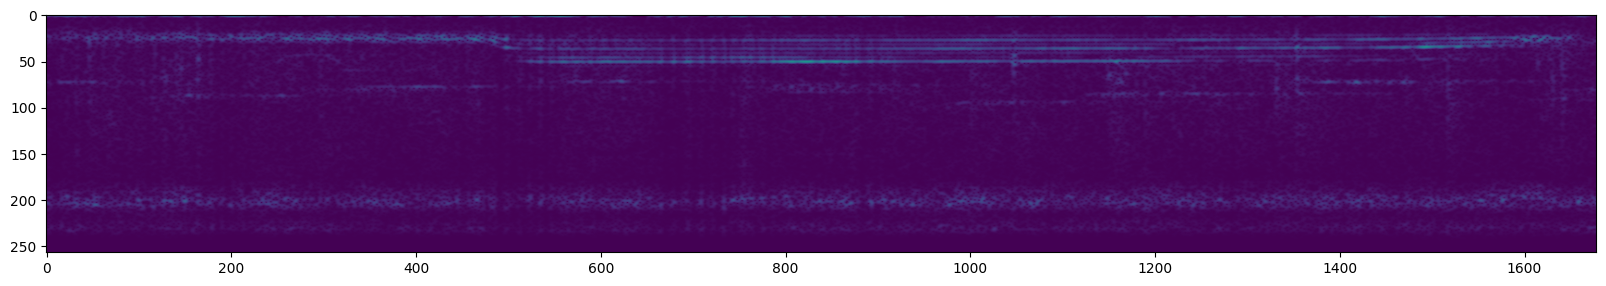

In [23]:
file_path,label = pos_dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectogram,label = preprocess(file_path,label)
print(len(spectogram),tf.transpose(spectogram).shape)
plt.figure(figsize=(20,7))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [24]:
# Data to pipeline
data = full_data.map(preprocess)
data = data.shuffle(buffer_size=1000).batch(16).prefetch(8)

## splitting training and testing data

In [25]:
total = int(len(data))
total

51

In [26]:
train_data = data.take(int(total*0.7))
test_data = data.skip(int(total*0.7)).take(int(total*0.2))
val_data = data.skip(int(total*0.7)).skip(int(total*0.2)).take(int(total*0.1))

In [27]:
print('training batch size',len(train_data))
print('validation batch size',len(val_data))
print('test size',len(test_data))

training batch size 35
validation batch size 5
test size 10


In [28]:
samples,labels = train_data.as_numpy_iterator().next()
samples.shape

(16, 1678, 257, 1)

In [29]:
labels

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

# Lets Build the neural Network

In [30]:
input_size = (1678, 257, 1)
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=input_size))
model.add(MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1676, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 838, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 836, 126, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 418, 63, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 421344)            0         
                                                                 
 dense (Dense)               (None, 128)               5

## training the model
we are training the model with 10 epochs with the `EarlyStopping callback` function to stop when there is the accurate resullts

In [32]:
hist = model.fit(train_data,epochs=10,
                 validation_data=test_data,
                 callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,
                                                            patience=5,
                                                            restore_best_weights=True))

Epoch 1/10
35/35 [==============================] - 101s 1s/step - loss: 1.2703 - recall: 0.7987 - precision: 0.7829 - val_loss: 0.0614 - val_recall: 0.9706 - val_precision: 0.9706
Epoch 2/10
35/35 [==============================] - 70s 1s/step - loss: 0.0354 - recall: 0.9792 - precision: 0.9930 - val_loss: 0.0355 - val_recall: 1.0000 - val_precision: 0.9773
Epoch 3/10
35/35 [==============================] - 89s 1s/step - loss: 0.0367 - recall: 0.9868 - precision: 0.9868 - val_loss: 0.0026 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
35/35 [==============================] - 73s 896ms/step - loss: 0.0109 - recall: 0.9809 - precision: 1.0000 - val_loss: 0.0082 - val_recall: 1.0000 - val_precision: 0.9762
Epoch 5/10
35/35 [==============================] - 57s 874ms/step - loss: 0.0042 - recall: 1.0000 - precision: 0.9936 - val_loss: 5.5722e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
35/35 [==============================] - 69s 1s/step - loss: 0.0039 - recall: 

# now lets plot the loss,precision and loss curves

In [39]:
def plot_curve(title,data,val_data):
  plt.title(title)
  plt.plot(hist.history[data],'r')
  plt.plot(hist.history[val_data],'b')
  plt.show()

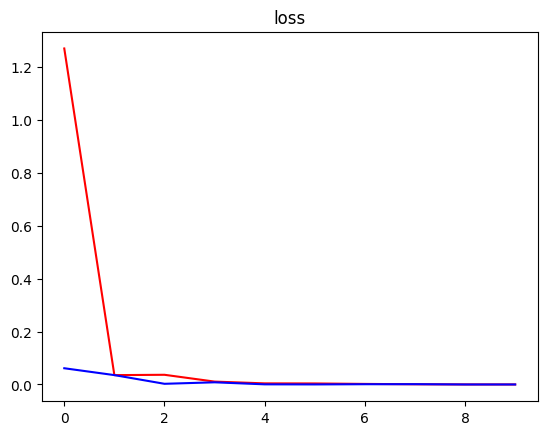

In [40]:
# plotting the loss curve
plot_curve('loss','loss','val_loss')

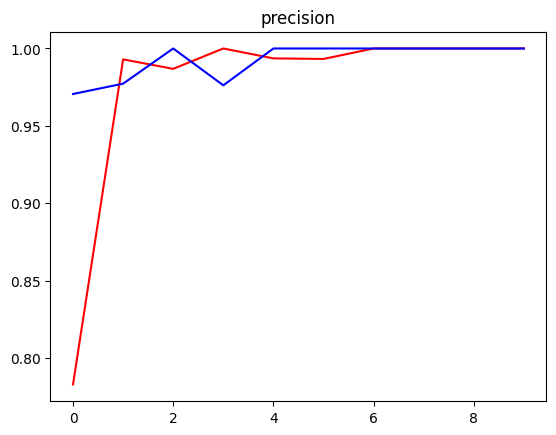

In [42]:
# plotting the precesion curve
plot_curve('precision','precision','val_precision')

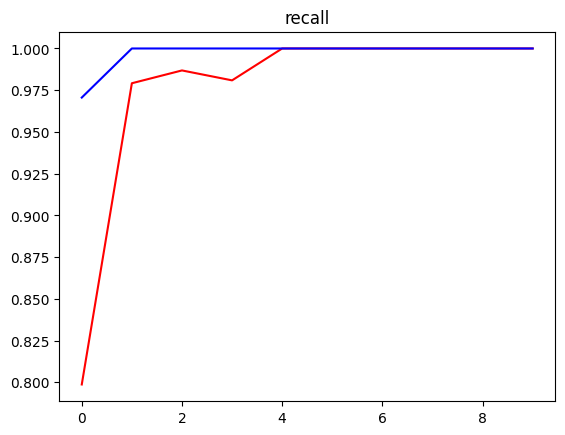

In [44]:
plot_curve('recall','recall','val_recall')

# lets make some predicitions for trained model

In [47]:
test_audio = []
test_labels = []
cnt = 0
for x_test,y_test in test_data.as_numpy_iterator():
  yhat = model.predict(x_test)
  yhat = [1 if predict > 0.5 else 0 for predict in yhat]
  print(f'Predicted labels: {yhat}')
  print(f'true labels: {y_test}')
  for idx,item in enumerate(yhat):
    if item == y_test[idx]:
      cnt+=1
  print(f'Accuracy is {(cnt/16*100)} %')
  cnt = 0

1/1 [==============================] - 0s 80ms/step
Predicted labels: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
true labels: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 0s 45ms/step
Predicted labels: [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
true labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 0s 47ms/step
Predicted labels: [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
true labels: [1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy is 100.0 %
1/1 [==============================] - 0s 44ms/step
Predicted labels: [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
true labels: [0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 0s 50ms/step
Predicted labels: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
true labels: [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
Accuracy i

#working with full audio

In [ ]:
detections = {}
for file_path in os.listdir(forest_data):
  file_path = os.path.join(forest_data,file)
  wav = downsample_audio(file_path,downsample_rate,is_forest=True)
